In [2]:
!pip install wfdb neurokit2 imbalanced-learn shap seaborn antropy nolds pywavelets opencv-python-headless joblib wrapt_timeout_decorator scikit-learn==1.1.3 rich==13.7.1 toolz==0.12.1 dtaidistance eli5

# Import Neccessary library

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from dtaidistance import dtw
import os
import wfdb
import math
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import neurokit2 as nk
import cv2
from scipy.signal import butter, filtfilt
import pywt
import warnings
from scipy.signal import iirnotch

# 1. Suppress warnings (temporarily)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Specify the directory where you want to save the downloaded files.
download_dir = 'mitdb_data'  # Change this to your preferred path

# Data Acquisition

In [4]:
# Check if the directory exists and contains files
if not os.path.exists('/kaggle/working/mitdb_data') or not os.listdir('/kaggle/working/mitdb_data'):
    wfdb.dl_database('mitdb', dl_dir=download_dir)
    print("Download complete. Files are saved in:", download_dir)
else:
    print("Dataset already exists in:", download_dir)

Dataset already exists in: mitdb_data


In [5]:
# Get a list of record names (without extensions)
record_names = [f.split('.')[0] for f in os.listdir(download_dir) if f.endswith('.hea')]

# Dictionary to store the number of samples per record
num_samples_dict = {}

for record in record_names:
    # Read the signal
    signal, fields = wfdb.rdsamp(os.path.join(download_dir, record))
    
    # Store the number of samples (frames)
    num_samples_dict[record] = signal.shape[0]
    
i = 0
# Display results
for record, num_samples in num_samples_dict.items():
    duration_seconds = num_samples / 360
    duration_minutes = duration_seconds / 60
    if i ==0:
        i+=1
        print(f"  Number of Frames (Samples): {num_samples}")
        print(f"  Duration: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)\n")

  Number of Frames (Samples): 650000
  Duration: 1805.56 seconds (30.09 minutes)



# Interactive widget

In [6]:
from IPython.display import display
import ipywidgets as widgets
import wfdb
import numpy as np
import pywt
import os
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt

# Define download directory and valid MIT-BIH records
download_dir = 'mitdb_data' 
valid_records = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', 
    '121', '122', '123', '124', '200', '201', '202', '203', '205', 
    '207', '208', '209', '210', '212', '213', '214', '215', '217', 
    '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

def interactive_ecg_preprocessor():
    # Widget controls
    record_selector = widgets.Dropdown(
        options=valid_records,
        value='100',
        description='Record:'
    )
    start_time = widgets.FloatSlider(
        value=0.0, min=0, max=30, step=0.5, description='Start Time (min):'
    )
    view_duration = widgets.FloatSlider(
        value=2.0, min=0.5, max=10.0, step=0.5, description='View Duration (s):'
    )

    # Processing parameters
    lowcut_slider = widgets.FloatSlider(
        value=0.5, min=0.1, max=10.0, step=0.1, description='Bandpass Low (Hz)'
    )
    highcut_slider = widgets.FloatSlider(
        value=45.0, min=10.0, max=100.0, step=1.0, description='Bandpass High (Hz)'
    )
    notch_freq_slider = widgets.FloatSlider(
        value=50.0, min=40.0, max=70.0, step=1.0, description='Notch Freq (Hz)'
    )
    notch_Q_slider = widgets.FloatSlider(
        value=30.0, min=10.0, max=100.0, step=1.0, description='Notch Q'
    )

    # Visualization controls
    phase_selector = widgets.Dropdown(
        options=['Notch Filtered', 'Bandpass Filtered'],
        value='Notch Filtered',
        description='Phase:'
    )
    raw_color_picker = widgets.ColorPicker(
        concise=True, description='Raw Color', value='black'
    )
    phase_color_picker = widgets.ColorPicker(
        concise=True, description='Phase Color', value='blue'
    )

    # Update display function
    def update_display(record_id, start_min, duration_sec,
                  lowcut, highcut, notch_freq, notch_Q,
                  phase, raw_color, phase_color):
        try:
            record = wfdb.rdrecord(os.path.join(download_dir, record_id))
            fs = record.fs
            ecg = record.p_signal[:, 0]
        
            # Time window
            start_sample = int(start_min * 60 * fs)
            end_sample = int(start_sample + duration_sec * fs)
            raw = ecg[start_sample:end_sample]
            t = np.arange(len(raw)) / fs
        
            # Notch filter (fixed implementation)
            w0 = notch_freq / (fs / 2)
            if w0 >= 1.0:  # Prevent invalid frequency
                w0 = 0.99
            b_notch, a_notch = iirnotch(w0, notch_Q)
            notch_filtered = filtfilt(b_notch, a_notch, raw)
        
            # Bandpass filter (fixed implementation)
            nyq = 0.5 * fs
            low = max(0.1, lowcut) / nyq  # Ensure lowcut > 0
            high = min(nyq - 0.1, highcut) / nyq  # Ensure highcut < nyq
            
            # Adjust if low >= high
            if low >= high:
                low = high - 0.1/nyq
            
            # Use lower filter order (4 might be too high for short segments)
            b_band, a_band = butter(2, [low, high], btype='band')
        
            # Pad signal to reduce edge effects
            padlen = min(3 * max(len(a_band), len(b_band)), len(raw) - 1)
            bandpass_filtered = filtfilt(b_band, a_band, notch_filtered, padlen=padlen)
        
            phase_dict = {
                'Notch Filtered': notch_filtered,
                'Bandpass Filtered': bandpass_filtered
            }
            selected_phase = phase_dict.get(phase, raw)
    
    
            # Plot 1: Time Domain
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
            ax1.plot(t, raw, label='Raw', color=raw_color, alpha=0.7)
            ax1.plot(t, selected_phase, label=phase, color=phase_color, alpha=0.7)
            ax1.set_title(f"Record {record_id}: Raw vs {phase} (Time Domain)\n"
                         f"Time: {start_min:.2f}–{(start_min + duration_sec / 60):.2f} min")
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("Amplitude")
            ax1.grid(True, alpha=0.3)
            ax1.legend()
    
            # Plot 2: Frequency Domain
            def plot_spectrum(signal, fs, label, color):
                freqs = np.fft.rfftfreq(len(signal), 1/fs)
                spectrum = np.abs(np.fft.rfft(signal))
                ax2.plot(freqs, spectrum, label=label, color=color)
    
            plot_spectrum(raw, fs, 'Raw', raw_color)
            plot_spectrum(selected_phase, fs, phase, phase_color)
    
            ax2.axvline(x=notch_freq, color='red', linestyle='--', alpha=0.8, label='Notch Freq')
            ax2.set_xlim(0, 100)  
            ax2.set_title("Frequency Spectrum")
            ax2.set_xlabel("Frequency (Hz)")
            ax2.set_ylabel("Magnitude")
            ax2.grid(True, alpha=0.3)
            ax2.legend()
    
            plt.tight_layout()
            plt.show()
    
        except Exception as e:
            print(f"Error: {e}")

    # UI layout
    ui = widgets.VBox([
        widgets.HBox([record_selector, start_time, view_duration]),
        widgets.HBox([notch_freq_slider, notch_Q_slider, lowcut_slider, highcut_slider]),
        widgets.HBox([phase_selector, raw_color_picker, phase_color_picker])
    ])

    out = widgets.interactive_output(update_display, {
        'record_id': record_selector,
        'start_min': start_time,
        'duration_sec': view_duration,
        'lowcut': lowcut_slider,
        'highcut': highcut_slider,
        'notch_freq': notch_freq_slider,
        'notch_Q': notch_Q_slider,
        'phase': phase_selector,
        'raw_color': raw_color_picker,
        'phase_color': phase_color_picker
    })

    display(ui, out)

# Run the updated widget
interactive_ecg_preprocessor()

Output()

## HRV Feature Extractions & Data Labeling

In [7]:
import os
import wfdb
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch
from tqdm import tqdm
import traceback
import pywt

# Configuration
download_dir = "mitdb_data"
output_file = "hrv_analysis_processed.csv"

def wavelet_denoise(signal, wavelet='db6', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') if i != 0 else c for i, c in enumerate(coeffs)]
    return pywt.waverec(denoised_coeffs, wavelet)

#classify segment as normal, abnormal, or unknown based on annotations
def get_segment_label(ann, start_sample, end_sample, fs):
    ann_samples = ann.sample
    ann_symbols = ann.symbol
    
    # Find indices of annotations within the segment
    in_segment = np.where((ann_samples >= start_sample) & (ann_samples <= end_sample))[0]
    
    if len(in_segment) == 0:
        return "unknown"  # No beats detected
    
    symbols = [ann_symbols[i] for i in in_segment]
    
    # Mark as "unknown" if any beat is "/", "f", or "Q"
    unknown_symbols = ["/", "f", "Q"]
    if any(symbol in unknown_symbols for symbol in symbols):
        return "unknown"
    
    # If fewer than 5 beats, mark as "unknown"
    if len(symbols) < 5:
        return "unknown"
    
    # Normal beat types
    normal_symbols = ['N', 'L', 'R', 'e', 'j']
    has_abnormal = any(symbol not in normal_symbols for symbol in symbols)
    
    return "abnormal" if has_abnormal else "normal"

def process_record(record_name, segment_duration_minutes=5.02):
    try:
        record_path = os.path.join(download_dir, record_name)
        if not os.path.exists(record_path + '.hea'):
            print(f"Record {record_name} not found - skipping")
            return None
            
        try:
            record = wfdb.rdrecord(record_path)
            ann = wfdb.rdann(record_path, 'atr')
        except Exception as e:
            print(f"Error loading {record_name}: {str(e)}")
            return None
        
        if record.p_signal is None or len(record.p_signal) == 0:
            print(f"No ECG signal found in {record_name}")
            return None
            
        ecg_signal = record.p_signal[:, 0]
        fs = record.fs
        
        try:
            # Signal preprocessing (notch + bandpass + wavelet)
            signal = ecg_signal.astype('float32')
            b_notch, a_notch = iirnotch(60.0 / (fs / 2), 40.0)
            notch_filtered = filtfilt(b_notch, a_notch, signal)
            b_band, a_band = butter(4, [0.5 / (0.5 * fs), 60.0 / (0.5 * fs)], btype='band')
            filtered_signal = filtfilt(b_band, a_band, notch_filtered)
            filtered_signal = wavelet_denoise(filtered_signal)[:len(ecg_signal)]
        except Exception as e:
            print(f"Filtering failed for {record_name}: {str(e)}")
            return None

        segment_length_samples = int(segment_duration_minutes * 60 * fs)
        num_segments = len(filtered_signal) // segment_length_samples
        segments = []

        for i in range(num_segments):
            start_idx = i * segment_length_samples
            end_idx = start_idx + segment_length_samples
            segment_signal = filtered_signal[start_idx:end_idx]
            
            if len(segment_signal) == 0:
                continue
                
            try:
                label = get_segment_label(ann, start_idx, end_idx, fs)
                hrv_features = {}
                
                # Attempt HRV analysis if >=5 beats exist
                info = nk.ecg_findpeaks(segment_signal, sampling_rate=fs, method="neurokit")
                peaks = info["ECG_R_Peaks"]
                
                if len(peaks) >= 5:  # Minimum for HRV analysis
                    hrv_features_df = nk.hrv(peaks, sampling_rate=fs, show=False)
                    if not hrv_features_df.empty:
                        exclude = ["ULF", "SDNNI", "SDNNd", "SDNNa", "SDANN", 
                                 "MFDFA", "DFA", "TINN", "PIP", "IALS"]
                        hrv_features = {
                            k: v for k, v in hrv_features_df.iloc[0].to_dict().items()
                            if not any(ex in k for ex in exclude)
                        }
                
                segments.append({
                    'record': record_name,
                    'segment': i + 1,
                    'actual_label': label,
                    **hrv_features
                })
                
            except Exception as e:
                print(f"Error in segment {i+1} of {record_name}:")
                traceback.print_exc()
                continue

        return segments
        
    except Exception as e:
        print(f"Critical error processing {record_name}:")
        traceback.print_exc()
        return None

if __name__ == "__main__":
    valid_records = [f.split('.')[0] for f in os.listdir(download_dir) if f.endswith('.dat')]
    results = []
    
    print(f"Processing {len(valid_records)} records...")
    for record_id in tqdm(valid_records):
        segments = process_record(record_id)
        if segments:
            results.extend(segments)
    
    if results:
        df = pd.DataFrame(results)
        # Ensure consistent column order
        cols = ['record', 'segment', 'actual_label'] + [c for c in df.columns if c not in ['record', 'segment', 'actual_label']]
        df = df[cols]
        df.to_csv(output_file, index=False)
        print(f"\nSaved {len(df)} segments to {output_file}")
        print("Class distribution:")
        print(df['actual_label'].value_counts())
    else:
        print("\nNo valid segments processed")

Processing 48 records...


100%|██████████| 48/48 [02:38<00:00,  3.30s/it]


Saved 240 segments to hrv_analysis_processed.csv
Class distribution:
actual_label
abnormal    184
normal       29
unknown      27
Name: count, dtype: int64


In [8]:
df.head(15)

,record,segment,actual_label,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,230,1,abnormal,755.954380,70.891876,25.750595,25.777788,0.093778,0.034064,752.777778,...,0.991858,6.331612,0.710588,1.466710,1.222608,1.718487,1.504853,1.609961,2.294088,0.543639
1,230,2,abnormal,903.547523,60.982521,41.403443,41.466025,0.067492,0.045823,908.333333,...,1.597944,6.155188,1.145968,1.648338,1.377635,1.845378,1.709292,1.786676,2.889969,0.857685
2,230,3,abnormal,870.700483,44.021898,31.484015,31.529839,0.050559,0.036159,875.000000,...,1.615480,5.883458,1.184734,1.594753,1.389829,2.055179,1.815299,1.779331,2.821318,0.879699
3,230,4,abnormal,787.693205,83.575356,26.124017,26.157537,0.106101,0.033165,786.111111,...,0.973621,6.645331,0.659797,1.307805,1.264473,1.683737,1.628456,1.580066,2.280222,0.427557
4,230,5,abnormal,775.351708,57.144938,35.812056,35.858532,0.073702,0.046188,777.777778,...,1.212169,6.003008,0.835463,1.002989,1.390330,1.825040,1.334790,1.615261,1.928742,0.599734
5,212,1,abnormal,646.677443,35.383410,26.575869,26.604287,0.054716,0.041096,644.444444,...,1.725510,5.565247,1.175487,1.392001,1.382341,2.080812,1.753562,1.903987,3.440422,0.820890
6,212,2,normal,638.599291,34.131228,23.521315,23.546240,0.053447,0.036833,638.888889,...,1.669606,5.548038,1.173955,1.562217,1.340071,2.057595,1.833895,1.835840,2.993028,0.812107
7,212,3,abnormal,640.408357,36.832094,25.049189,25.076006,0.057513,0.039114,641.666667,...,1.600414,5.643704,1.128729,1.414458,1.371758,2.313495,1.739309,1.775651,3.531895,0.833966
8,212,4,abnormal,657.273392,36.288800,25.265179,25.292899,0.055211,0.038439,655.555556,...,1.712207,5.585941,1.185162,1.488555,1.301267,2.070636,1.751451,1.806922,3.463913,0.794185
9,212,5,abnormal,676.680461,42.928739,27.187674,27.218481,0.063440,0.040178,672.222222,...,1.398157,5.636665,1.044599,1.280851,1.382790,1.648130,1.484359,1.836616,2.274932,0.893008


In [9]:
# Load dataset from saved file
df = pd.read_csv('/kaggle/working/hrv_analysis_processed.csv',)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   record            240 non-null    int64  
 1   segment           240 non-null    int64  
 2   actual_label      240 non-null    object 
 3   HRV_MeanNN        240 non-null    float64
 4   HRV_SDNN          240 non-null    float64
 5   HRV_RMSSD         240 non-null    float64
 6   HRV_SDSD          240 non-null    float64
 7   HRV_CVNN          240 non-null    float64
 8   HRV_CVSD          240 non-null    float64
 9   HRV_MedianNN      240 non-null    float64
 10  HRV_MadNN         240 non-null    float64
 11  HRV_MCVNN         240 non-null    float64
 12  HRV_IQRNN         240 non-null    float64
 13  HRV_SDRMSSD       240 non-null    float64
 14  HRV_Prc20NN       240 non-null    float64
 15  HRV_Prc80NN       240 non-null    float64
 16  HRV_pNN50         240 non-null    float64
 1

**time domain** = ['MeanNN', 'SDNN', 'RMSSD', 'SDSD', 'CVNN', 'CVSD', 'MedianNN', 'MadNN', 'MCVNN', 'IQRNN',
                 'SDRMSSD', 'Prc20NN', 'Prc80NN', 'pNN50', 'pNN20', 'MinNN', 'MaxNN']

**frequency domain**= ['VLF', 'LF', 'HF', 'VHF', 'TP', 'LFHF', 'LFn', 'HFn', 'LnHF']

**nonlinear** = ['SD1', 'SD2', 'SD1SD2', 'S', 'CSI', 'CVI', 'CSI_Modified', 'SI', 'AI', 'PI',
                      'SD1d', 'SD1a', 'SD2d', 'SD2a', 'ApEn', 'SampEn', 'ShanEn', 'FuzzyEn', 'MSEn',
                      'CMSEn', 'RCMSEn', 'CD', 'HFD', 'KFD', 'LZC']
                    

# Feature Scalling

Means after scaling:
 HRV_MeanNN   -5.921189e-17
HRV_SDNN     -1.850372e-17
HRV_RMSSD    -3.330669e-17
HRV_SDSD      2.960595e-17
HRV_CVNN      2.590520e-17
                  ...     
HRV_RCMSEn    4.144833e-16
HRV_CD        1.184238e-16
HRV_HFD      -1.569115e-15
HRV_KFD       8.881784e-17
HRV_LZC      -4.662937e-16
Length: 61, dtype: float64

Standard deviations after scaling:
 HRV_MeanNN    1.00209
HRV_SDNN      1.00209
HRV_RMSSD     1.00209
HRV_SDSD      1.00209
HRV_CVNN      1.00209
               ...   
HRV_RCMSEn    1.00209
HRV_CD        1.00209
HRV_HFD       1.00209
HRV_KFD       1.00209
HRV_LZC       1.00209
Length: 61, dtype: float64


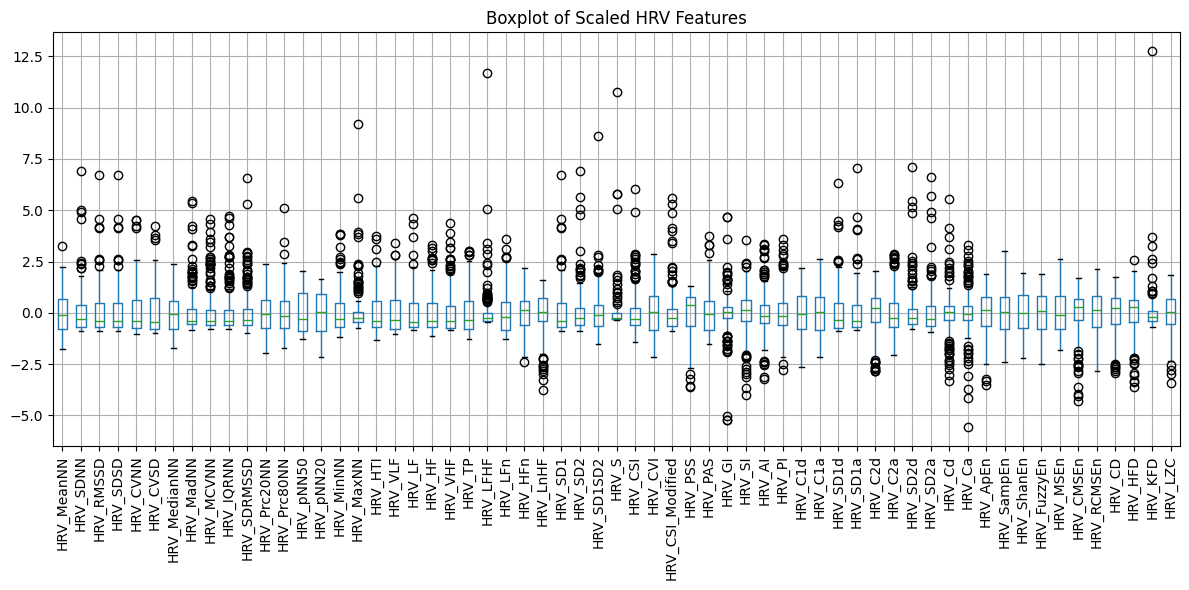

In [10]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Drop non-feature columns
X = df.drop(['record', 'segment', 'actual_label'], axis=1)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Check mean and std
print("Means after scaling:\n", X_scaled_df.mean())
print("\nStandard deviations after scaling:\n", X_scaled_df.std())

# Boxplot for visual inspection
plt.figure(figsize=(12, 6))
X_scaled_df.boxplot()
plt.title("Boxplot of Scaled HRV Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Data for Clustering

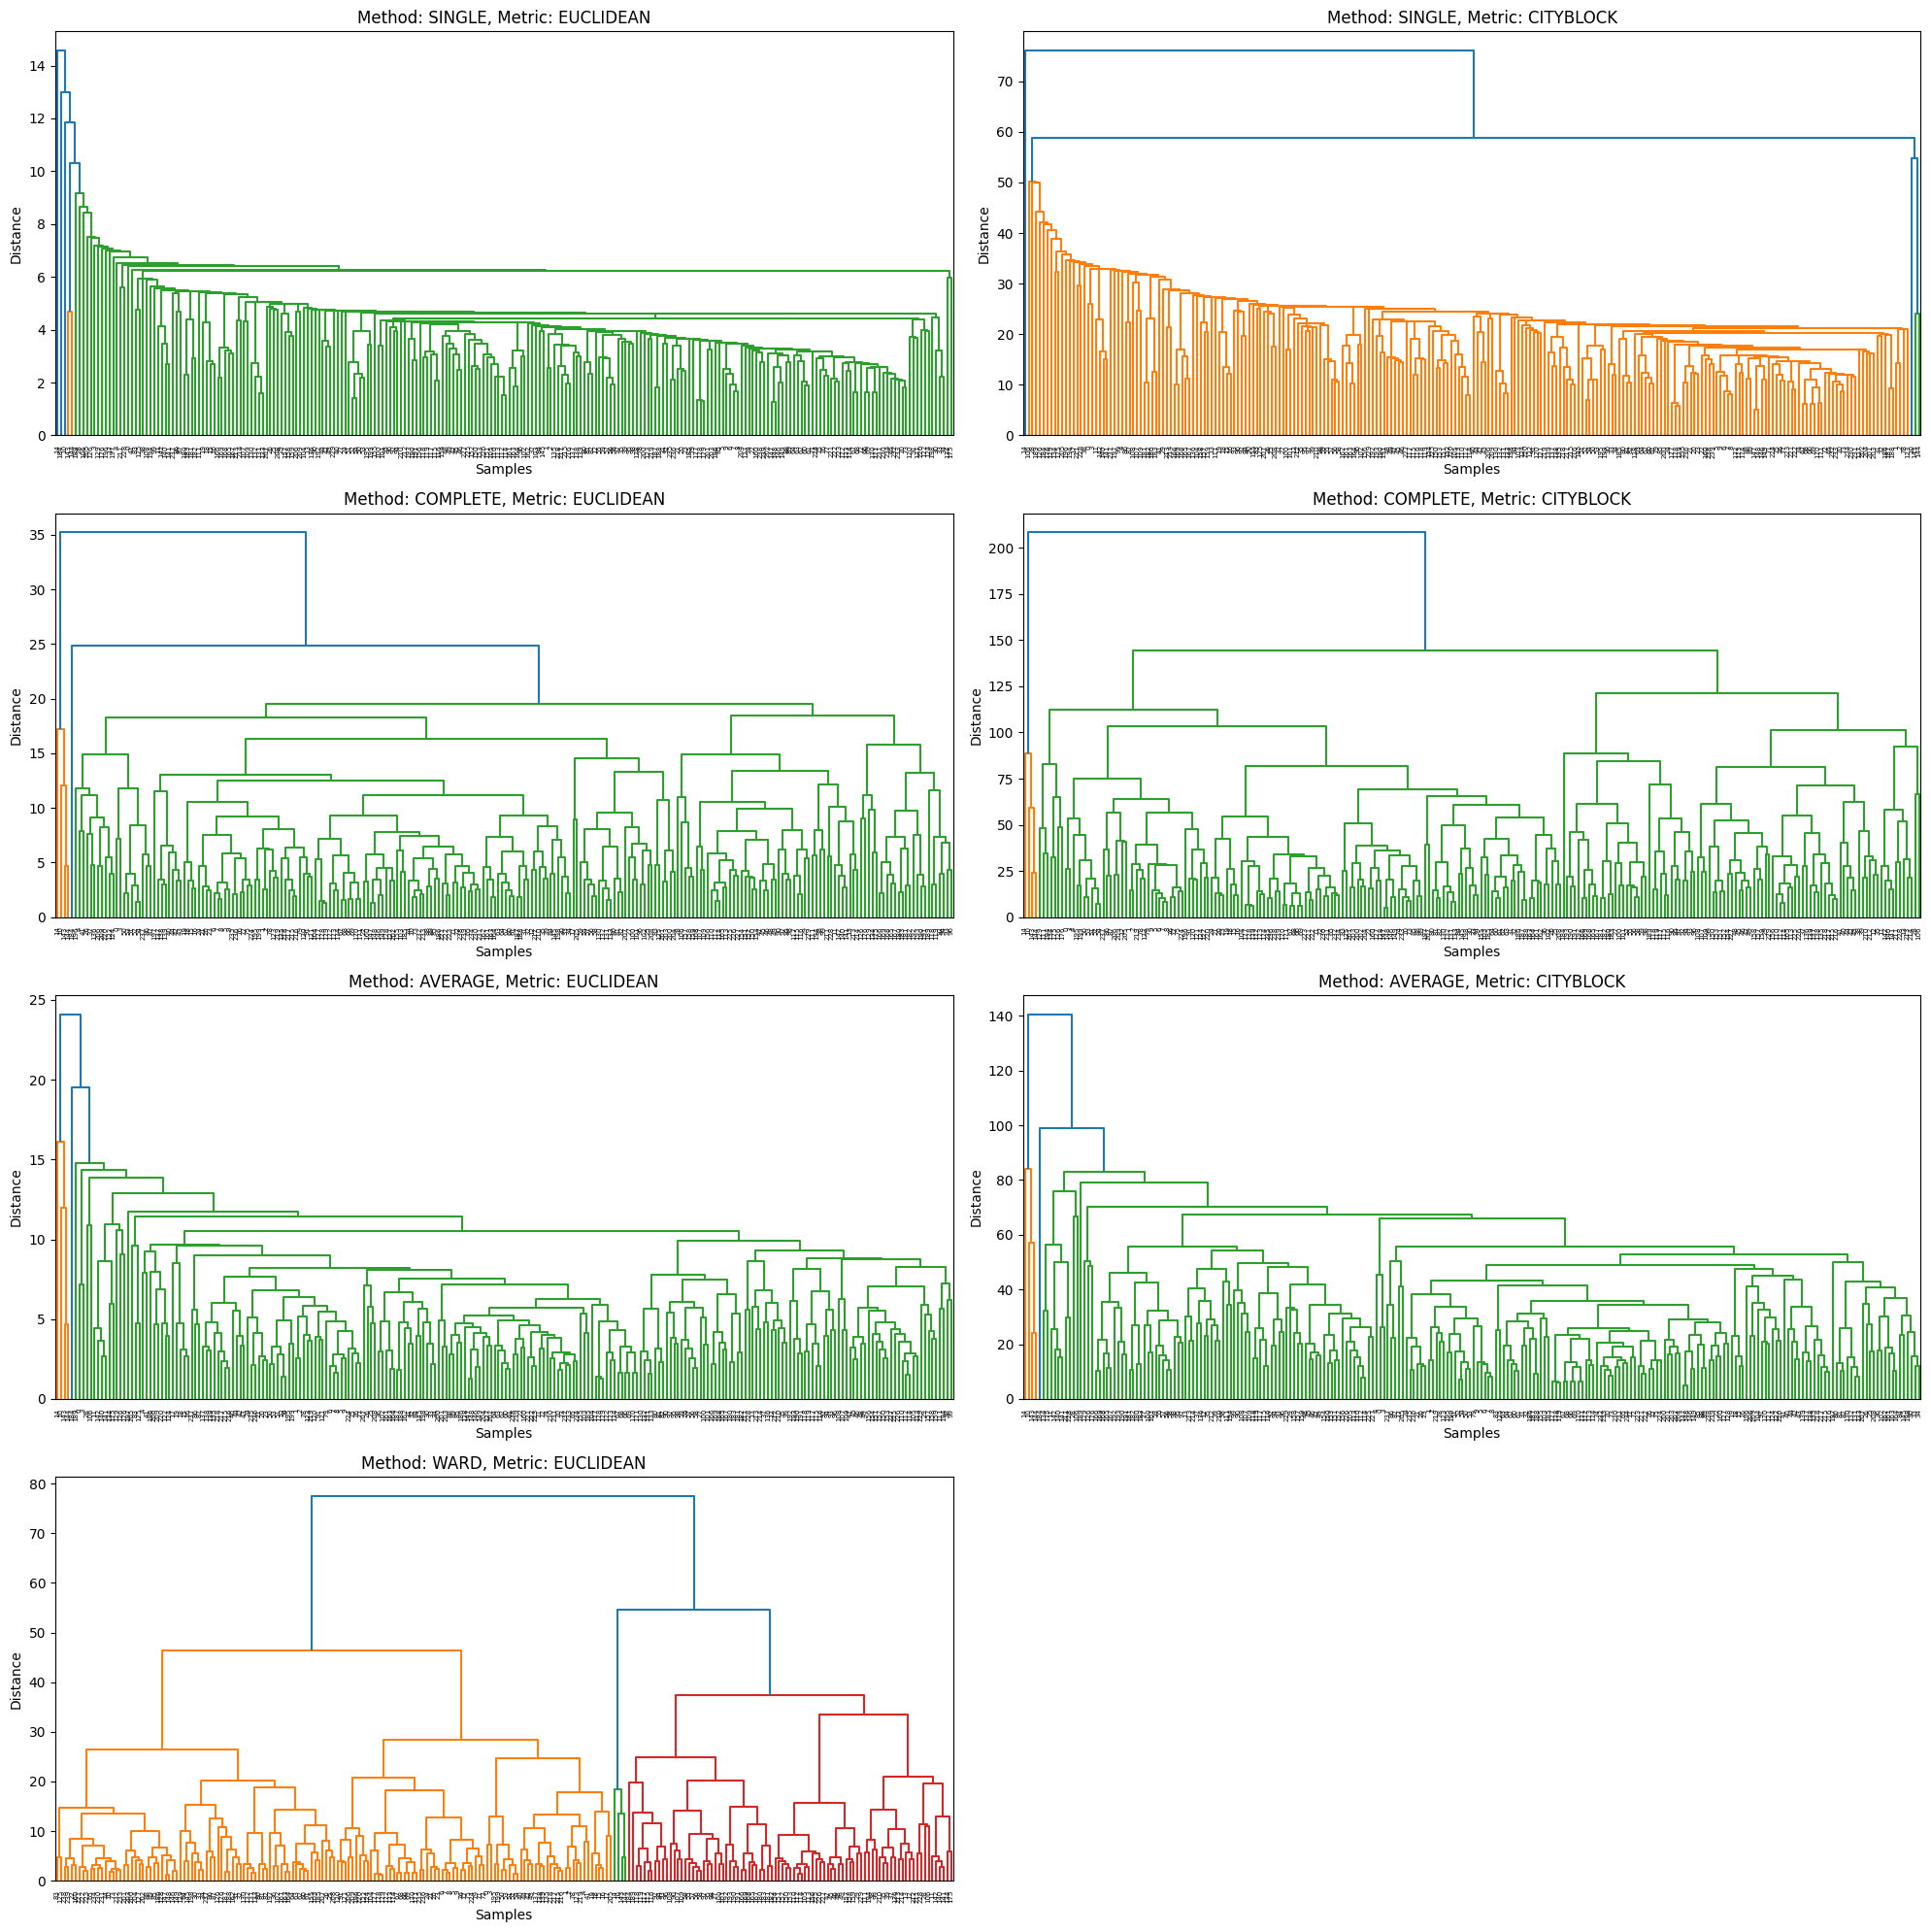

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

linkage_methods = ['single', 'complete', 'average', 'ward']
distance_metrics = ['euclidean', 'cityblock']  # Note: 'ward' only works with 'euclidean'

# create a figure with subplots
fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), 
                         figsize=(20, 5*len(linkage_methods)))

if len(linkage_methods) == 1 or len(distance_metrics) == 1:
    axes = np.reshape(axes, (len(linkage_methods), len(distance_metrics)))

# Loop through all combinations
for i, method in enumerate(linkage_methods):
    for j, metric in enumerate(distance_metrics):
        # skip ward, only works with euclidean
        if method == 'ward' and metric != 'euclidean':
            axes[i,j].axis('off')
            continue
            
        try:
            # clustering
            Z = linkage(X_scaled, method=method, metric=metric)
            
            # Plot dendrogram
            dendrogram(Z, ax=axes[i,j])
            axes[i,j].set_title(f"Method: {method.upper()}, Metric: {metric.upper()}")
            axes[i,j].set_xlabel("Samples")
            axes[i,j].set_ylabel("Distance")
        except Exception as e:
            axes[i,j].axis('off')
            print(f"Failed for {method}/{metric}: {str(e)}")

plt.tight_layout()
plt.show()

## Determine Optimal Clusters

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

# Define all combinations to test
linkage_methods = ['single', 'complete', 'average', 'ward']
distance_metrics = ['euclidean', 'cityblock']
cluster_range = range(2, 6)  # Testing 2 to 5 clusters

# Store results in a DataFrame
results = []

# Loop through all combinations
for method in linkage_methods:
    for metric in distance_metrics:
        # Skip invalid combinations
        if method == 'ward' and metric != 'euclidean':
            continue
            
        try:
            # Perform hierarchical clustering
            Z = linkage(X_scaled, method=method, metric=metric)
            
            # Evaluate different numbers of clusters
            for k in cluster_range:
                labels = fcluster(Z, k, criterion="maxclust")
                
                # Only calculate scores if we have more than 1 cluster and all points aren't in one cluster
                if len(np.unique(labels)) > 1:
                    silhouette = silhouette_score(X_scaled, labels)
                    davies_bouldin = davies_bouldin_score(X_scaled, labels)
                else:
                    silhouette = -1  # Worst possible score
                    davies_bouldin = float('inf')  # Worst possible score
                
                results.append({
                    'Method': method,
                    'Metric': metric,
                    'Clusters': k,
                    'Silhouette': silhouette,
                    'Davies_Bouldin': davies_bouldin
                })
                
        except Exception as e:
            print(f"Failed for {method}/{metric}: {str(e)}")
            continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find best configuration by each metric
best_silhouette = results_df.loc[results_df['Silhouette'].idxmax()]
best_db = results_df.loc[results_df['Davies_Bouldin'].idxmin()]

print("\nBest configuration by Silhouette Score:")
print(best_silhouette[['Method', 'Metric', 'Clusters', 'Silhouette']])
print("\nBest configuration by Davies-Bouldin Index:")
print(best_db[['Method', 'Metric', 'Clusters', 'Davies_Bouldin']])

# Alternatively, you can print all results sorted by each metric
print("\nAll results sorted by Silhouette Score (descending):")
print(results_df.sort_values('Silhouette', ascending=False).head(10))

print("\nAll results sorted by Davies-Bouldin Index (ascending):")
print(results_df.sort_values('Davies_Bouldin').head(10))

# Test just ward + euclidean
method = 'ward'
metric = 'euclidean'
Z = linkage(X, method=method, metric=metric)
for k in cluster_range:
    labels = fcluster(Z, k, criterion="maxclust")
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    print(f"ward/euclidean k={k}: silhouette={silhouette}, db={davies_bouldin}")



Best configuration by Silhouette Score:
Method           single
Metric        euclidean
Clusters              2
Silhouette     0.667672
Name: 0, dtype: object

Best configuration by Davies-Bouldin Index:
Method               single
Metric            euclidean
Clusters                  2
Davies_Bouldin     0.231567
Name: 0, dtype: object

All results sorted by Silhouette Score (descending):
      Method     Metric  Clusters  Silhouette  Davies_Bouldin
0     single  euclidean         2    0.667672        0.231567
4     single  cityblock         2    0.667672        0.231567
8   complete  euclidean         2    0.580826        0.679373
20   average  cityblock         2    0.580826        0.679373
16   average  euclidean         2    0.580826        0.679373
12  complete  cityblock         2    0.580826        0.679373
5     single  cityblock         3    0.526636        0.554559
6     single  cityblock         4    0.506586        0.374935
9   complete  euclidean         3    0.484806   

In [13]:
from tabulate import tabulate

# Prepare simplified results
simple_results = []

for method in linkage_methods:
    for metric in distance_metrics:
        if method == 'ward' and metric != 'euclidean':
            continue
            
        try:
            Z = linkage(X_scaled, method=method, metric=metric)
            labels = fcluster(Z, 2, criterion="maxclust")-1  # Force 2 clusters
            
            # Count cluster sizes
            cluster_counts = pd.Series(labels).value_counts()
            
            # Determine which cluster is Normal (larger) and Arrythmic (smaller)
            normal_cluster = cluster_counts.idxmax()
            normal_count = cluster_counts.max()
            arrythmic_count = cluster_counts.min()
            
            simple_results.append([
                f"{method}/{metric}",
                normal_count,
                arrythmic_count,
                f"{normal_count/(normal_count+arrythmic_count):.1%}",
                f"{arrythmic_count/(normal_count+arrythmic_count):.1%}"
            ])
            
        except Exception as e:
            print(f"Error with {method}/{metric}: {str(e)}")
            continue

# Display table
headers = [
    "Configuration", 
    "Normal Count", 
    "Arrythmic Count",
    "Normal %",
    "Arrythmic %"
]

print(tabulate(simple_results, headers=headers, tablefmt="grid"))

+--------------------+----------------+-------------------+------------+---------------+
| Configuration      |   Normal Count |   Arrythmic Count | Normal %   | Arrythmic %   |
+====================+================+===================+============+===============+
| single/euclidean   |            239 |                 1 | 99.6%      | 0.4%          |
+--------------------+----------------+-------------------+------------+---------------+
| single/cityblock   |            239 |                 1 | 99.6%      | 0.4%          |
+--------------------+----------------+-------------------+------------+---------------+
| complete/euclidean |            236 |                 4 | 98.3%      | 1.7%          |
+--------------------+----------------+-------------------+------------+---------------+
| complete/cityblock |            236 |                 4 | 98.3%      | 1.7%          |
+--------------------+----------------+-------------------+------------+---------------+
| average/euclidean  

## SMOTE Oversampling

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

# Step 1: Get cluster labels using linkage
Z = linkage(X_scaled, method='ward', metric='euclidean')
df['cluster_label'] = fcluster(Z, t=2, criterion='maxclust') - 1  # Binary label

# Step 2: Define target
y = df['cluster_label']

# Step 3: Prepare features — drop non-features
X = df.drop(columns=['record', 'segment', 'cluster_label', 'actual_label'])


# Step 4: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Use a safe value for k_neighbors
min_samples = y_train.value_counts().min()
safe_k = max(1, min(5, min_samples - 1))

# Step 7: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=safe_k)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Step 8: Confirm class balance
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts())


Class distribution after SMOTE:
cluster_label
0    104
1    104
Name: count, dtype: int64


## Split Train and Test set with 20% for testing

In [15]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42,stratify=y)

print("\nShapes after splitting:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes after splitting:
X_train: (192, 61)
X_test: (48, 61)
y_train: (192,)
y_test: (48,)


## Modeling

In [16]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# 1. Initialize the classifier with fixed random seed
clf = LGBMClassifier(verbose=-1, random_state=42)

# 2. Train on the SMOTE-resampled training data
clf.fit(X_res, y_res)

# 3. Predict on original (imbalanced) test set
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100]
}

grid = GridSearchCV(LGBMClassifier(verbose=-1, random_state=42), param_grid,
                    scoring='f1_weighted', cv=3, n_jobs=-1)
grid.fit(X_res, y_res)

best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

# 4. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# 5. Display Results
print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)



Evaluation Metrics:
Accuracy: 0.9791666666666666
Precision: 0.9802631578947368
Recall: 0.9791666666666666
F1-score: 0.9792716445258819

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.95      1.00      0.97        18

    accuracy                           0.98        48
   macro avg       0.97      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48

Confusion Matrix:
 [[29  1]
 [ 0 18]]


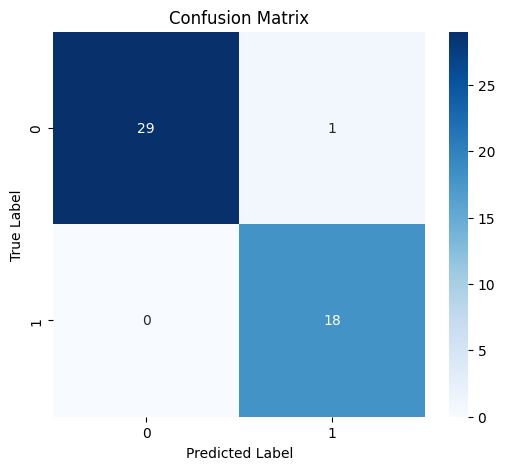

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Explainability AI (ELI5)

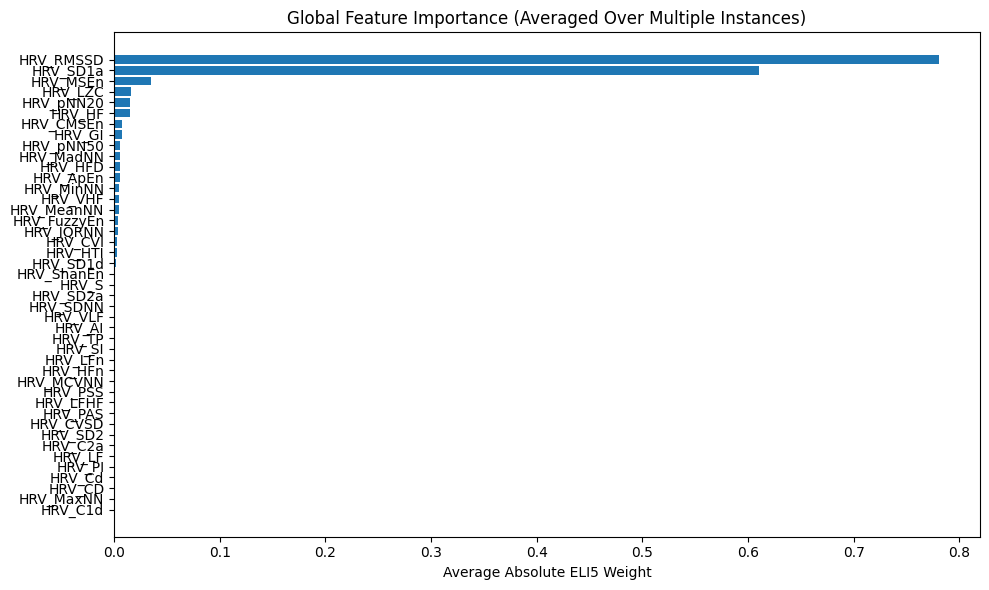

Local explanation (signed weights):


Explanation(estimator='LGBMClassifier(learning_rate=0.01, num_leaves=15, random_state=42, verbose=-1)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='HRV_RMSSD', weight=0.6187198902357485, std=None, value=-0.2354813270415585), FeatureWeight(feature='HRV_SD1a', weight=0.5055182479977994, std=None, value=-0.26508404771318067), FeatureWeight(feature='HRV_CMSEn', weight=0.010618539326250322, std=None, value=-0.05075745470193645), FeatureWeight(feature='HRV_LZC', weight=0.008910671340418798, std=None, value=-0.562577331738259), FeatureWeight(feature='HRV_VHF', weight=0.0052699799683019275, std=None, value=-0.28553944655671976), FeatureWeight(feature='HRV_HFD', weight=0.00337552623781758, std=None, value=-0.5844774038114895), FeatureWeight(feature='HRV_S', weight=0.0030219049114416034, std=None, value=-0.21851092700583813), FeatureWeight(feature='HRV_MeanNN', weight=0.0029336398215161572, std=None, value=1.65723106097675), FeatureWeight(feature='HRV_SDNN', weight=0.0027865952481858254, std=None, value=-0.18079747677367694), FeatureWeight(feature='HRV_IQRNN', weight=0.0023133906217719536, std=None, value=-0.2784831369757765), FeatureWeight(feature='HRV_TP', weight=0.0017410781889367413, std=None, value=-0.027530088855885045), FeatureWeight(feature='HRV_ShanEn', weight=0.0013886088574029103, std=None, value=0.23559087615724464), FeatureWeight(feature='HRV_HTI', weight=0.00013877497901054574, std=None, value=0.10363797646686183), FeatureWeight(feature='HRV_SD2', weight=8.729427909365955e-05, std=None, value=-0.08539334998957007)], neg=[FeatureWeight(feature='HRV_MadNN', weight=-0.01892429960868624, std=None, value=-0.2100037571197208), FeatureWeight(feature='HRV_CVI', weight=-0.012821799623285602, std=None, value=0.2531992670984422), FeatureWeight(feature='HRV_pNN20', weight=-0.010362852455697331, std=None, value=0.3535197203930261), FeatureWeight(feature='HRV_HF', weight=-0.01027400861688494, std=None, value=0.41323083831325064), FeatureWeight(feature='HRV_SD1d', weight=-0.00873324674611615, std=None, value=-0.20612451071090707), FeatureWeight(feature='HRV_SD2a', weight=-0.0029851534446794625, std=None, value=-0.12668326936558238), FeatureWeight(feature='HRV_MCVNN', weight=-0.00012144301523228825, std=None, value=-0.4239664381600893), FeatureWeight(feature='HRV_FuzzyEn', weight=-0.00010693590170651052, std=None, value=-0.5458417584122199), FeatureWeight(feature='HRV_LFHF', weight=-2.930173721522357e-05, std=None, value=-0.34933156791065684), FeatureWeight(feature='HRV_HFn', weight=-6.780858799206729e-06, std=None, value=1.0110851713664597), FeatureWeight(feature='HRV_PSS', weight=-4.107328048600159e-06, std=None, value=-3.208460513546923)], pos_remaining=0, neg_remaining=0), proba=0.8522367970441743, score=-1.7522534066157844, weighted_


Local explanation (absolute weights):


,Feature,Absolute Weight
0,HRV_RMSSD,0.619
1,HRV_SD1a,0.506
2,HRV_MadNN,0.019
3,HRV_CVI,0.013
4,HRV_CMSEn,0.011
5,HRV_pNN20,0.010
6,HRV_HF,0.010
7,HRV_LZC,0.009
8,HRV_SD1d,0.009
9,HRV_VHF,0.005


In [142]:
import eli5
from eli5 import explain_prediction, format_as_text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming:
# best_clf = your trained LightGBM model
# X = your full feature DataFrame (training or full dataset)
# X_test = your test data as a NumPy array or DataFrame

# 1. GLOBAL: Compute average absolute ELI5 feature weights over multiple instances
feature_weights = {f: [] for f in X.columns}

for i in range(min(50, len(X_test))):
    explanation = explain_prediction(
        best_clf,
        X_test[i],
        feature_names=X.columns.tolist()
    )
    
    # Collect absolute weights from positive and negative contributions
    weights = explanation.targets[0].feature_weights.pos + explanation.targets[0].feature_weights.neg
    
    for w in weights:
        feature_name = w.feature
        weight_value = abs(w.weight)
        if feature_name in feature_weights:
            feature_weights[feature_name].append(weight_value)

# Compute average weights and sort descending
avg_weights = {f: np.mean(ws) for f, ws in feature_weights.items() if ws}
sorted_weights = sorted(avg_weights.items(), key=lambda x: x[1], reverse=True)

# Plot global average feature importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_weights], [x[1] for x in sorted_weights])
plt.xlabel("Average Absolute ELI5 Weight")
plt.title("Global Feature Importance (Averaged Over Multiple Instances)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. LOCAL: Prepare test data as DataFrame if needed
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=X.columns)
else:
    X_test_df = X_test

# Select one instance index to explain locally
instance_idx = 0
sample = X_test_df.iloc[instance_idx]

# Function to print local explanation
def show_local_signed_weights(model, sample, feature_names):
    exp = explain_prediction(model, sample, feature_names=feature_names)

    exp.targets[0].feature_weights.pos = [w for w in exp.targets[0].feature_weights.pos if w.feature != '<BIAS>']
    exp.targets[0].feature_weights.neg = [w for w in exp.targets[0].feature_weights.neg if w.feature != '<BIAS>']
    
    display(exp)

def show_local_abs_weights(model, sample, feature_names):
    exp = explain_prediction(model, sample, feature_names=feature_names)
    weights = exp.targets[0].feature_weights.pos + exp.targets[0].feature_weights.neg
    
    filtered = [(w.feature, abs(w.weight)) for w in weights if w.feature != '<BIAS>']
    filtered.sort(key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(filtered, columns=["Feature", "Absolute Weight"])
    display(df.style.format({"Absolute Weight": "{:.3f}"}))


# Usage:
print("Local explanation (signed weights):")
show_local_signed_weights(best_clf, sample, X.columns.tolist())

print("\nLocal explanation (absolute weights):")
show_local_abs_weights(best_clf, sample, X.columns.tolist())
